# Connecting Symuvia via Python 

This notebook explains the way a simple connection is created from `Python` towards `Symuvia`. In this case a simple simulation is run step by step and data is retrieved and stored within a `sqlite` file. At end data is imported and trajectories are plotted 

In [6]:
import os 
from ctypes import cdll, create_string_buffer, c_int, byref, c_bool


from sqlalchemy import create_engine, MetaData
from sqlalchemy import Table, Column, String, Integer, Float 
from sqlalchemy import insert, delete, select, case, and_

from xmltodict import parse
from collections import OrderedDict

import pandas as pd
import matplotlib.pyplot as plt

import altair as alt
alt.renderers.enable('default')
print(alt.renderers.active)

from vega_datasets import data as data_vega

import seaborn as sns

default


## Connect Symuvia 

In this case connect to the simulator. First define the `libSymuVia.dylib` file 

In [7]:
dir_path = os.getcwd()
lib_path_name = ('..','Symuvia','Contents','Frameworks','libSymuVia.dylib')

In [8]:
full_name = os.path.join(dir_path,*lib_path_name)

Load the lybrary

In [10]:
symuvialib = cdll.LoadLibrary(full_name)     

Determine the full path of the file to be simulated 

In [12]:
file_path = ('..', 'Network', 'Merge.xml')
file_name = os.path.join(dir_path, *file_path)

### Launching the symulation 

Load the network 

In [14]:
m = symuvialib.SymLoadNetworkEx(file_name.encode('UTF8'))

Check creation / load database 

In [43]:
engine_path = ('..','Output','SymOut.sqlite')
engine_name = os.path.join(os.path.sep,*engine_path)
engine_full_name = os.path.join(dir_path,*engine_path)
engine_call = 'sqlite://'+engine_name
engine = create_engine(engine_call)
metadata = MetaData()

if os.path.isfile(engine_full_name):
    connection = engine.connect()    
    traj = Table('traj', metadata, autoload=True, autoload_with=engine)
    stmt = delete(traj)
    results = connection.execute(stmt)
else:
    traj = Table('traj', metadata,
             Column('ti', Float()),
             Column('id', Integer()),
             Column('type', String(3)),
             Column('tron', String(10)),
             Column('voie', Integer()),
             Column('dst', Float()),
             Column('abs', Float()),
             Column('vit', Float()),
             Column('ldr', Integer()),
             Column('spc', Float()),
             Column('vld', Float()))
    dyn = Table()
    metadata.create_all(engine)
    connection = engine.connect()

Create pointers to retrieve data 

In [44]:
sRequest = create_string_buffer(10000)
bEnd = c_bool(False)
bSecond = c_bool(True)

Functions during running time 

In [45]:
# Parser data_vehicle
def typedict(veh_dict):
    data = {'id': int(veh_dict['@id']),
        'type': veh_dict['@type'],
        'tron': veh_dict['@tron'],
        'voie': int(veh_dict['@voie']),
        'dst': float(veh_dict['@dst']),
        'abs': float(veh_dict['@abs']),
        'vit': float(veh_dict['@vit']),
       }
    return data 

### Network information

Information regarding V2V communicatioin is computed. In particular which is the connectivity in this case only a single leader is identified 

In [46]:
# Identify Leader 

def queueveh(dLeader, veh):
    if veh['tron'] in dLeader.keys():
        if  veh['id'] not in dLeader[veh['tron']]:
            dLeader[veh['tron']].append(veh['id'])
    else:
        dLeader[veh['tron']] = [veh['id']]
    return dLeader 

def getlead(dLeader, veh):
    idx = dLeader[veh['tron']].index(veh['id'])
    if idx != 0:
        return dLeader[veh['tron']][idx-1]
    else: 
        return dLeader[veh['tron']][idx]
        

### Control information 

In this case functions to compute `spacing` and leaders' information is provided 

In [47]:
# Spacing 

def getspace(lTrajVeh):    
    try: 
        # Case single vehicle
        if lTrajVeh['id'] == lTrajVeh['ldr']:
            return [{'spc':0.0}] 
        else:
            # Last vehicle
            # Leader out of Network @ ti
            return [{'spc':None}] 
    except (TypeError, IndexError):        
        # Multiple veh @ ti
        space = []
        for veh in lTrajVeh:
            if veh['id'] == veh['ldr']:
                space.append(0.0)
            else:             
                veh_pos = veh['abs']
                ldr_id = veh['ldr']
                ldr_pos = [ldr['abs'] for ldr in lTrajVeh if ldr['id']==ldr_id]
                if ldr_pos:
                    space.append(ldr_pos[0]-veh_pos)
                else:
                    # Leader out of Network @ ti
                    space.append(0.0)
        space_dct = [{'spc': val} for val in space]
        return space_dct

def getleaderspeed(lTrajVeh):
    try: 
        # Case single vehicle
        if lTrajVeh['id'] == lTrajVeh['ldr']:
            return [{'vld': lTrajVeh['vit']}]
        else:
            # Leader out of Network @ ti
            return [{'vld':None}]                     
    except (TypeError, IndexError):        
        # Multiple veh @ ti
        speedldr = []
        for veh in lTrajVeh:
            if veh['id'] == veh['ldr']:
                speedldr.append(veh['vit'])
            else:             
                ldr_id = veh['ldr']
                ldr_vit = [ldr['vit'] for ldr in lTrajVeh if ldr['id']==ldr_id]
                if ldr_vit:
                    speedldr.append(ldr_vit[0])
                else:
                    speedldr.append(veh['vit'])
        speedldr_dct = [{'vld': val} for val in speedldr]
        return speedldr_dct    
    
def updatelist(lTrajVeh,lDict):
    try:
        lTrajVeh.update(lDict[0])
    except AttributeError:
        for d,s in zip(lTrajVeh,lDict):
            d.update(s)
    return lTrajVeh



### Control law 
 
Control law for a specific set of parameters 

Iterate step by step over the simulation

In [48]:
N = 500 # Simulation steps

# Start simulation from beginning
m = symuvialib.SymLoadNetworkEx(file_name.encode('UTF8'))

# Clean table
stmt = delete(traj)
results = connection.execute(stmt)

step = iter(range(N)) 
stmt = insert(traj)

#for step in steps: 
bSuccess = 2 
while bSuccess>0:
    try:
        next(step)
        bSuccess =  symuvialib.SymRunNextStepEx(sRequest, True, byref(bEnd))
        dParsed = parse(sRequest.value.decode('UTF8'))
        ti = dParsed['INST']['@val']
        if dParsed['INST']['TRAJS'] is None:
            print('No vehicles in the network at time: {}'.format(ti))
        else:            
            lVehOD = dParsed['INST']['TRAJS']['TRAJ']      
            lTrajVeh = []
            try:
                lTrajVeh = typedict(lVehOD)
                lTrajVeh['ti'] = ti
                dLeader = {lTrajVeh['tron']: [lTrajVeh['id']]}
                lTrajVeh['ldr'] = getlead(dLeader, lTrajVeh)                  
            except TypeError:
                # Multiple veh @ ti
                for i,  veh in enumerate(lVehOD):
                    TrajVeh = typedict(veh)
                    TrajVeh['ti'] = ti
                    dLeader = queueveh(dLeader, TrajVeh)
                    TrajVeh['ldr'] = getlead(dLeader, TrajVeh)
                    lTrajVeh.append(TrajVeh)
            lSpc = getspace(lTrajVeh)
            lLdrV = getleaderspeed(lTrajVeh)
            lTrajVeh = updatelist(lTrajVeh,lSpc)
            lTrajVeh = updatelist(lTrajVeh,lLdrV)
            results = connection.execute(stmt,lTrajVeh)
            print('{} vehicles in the network at time: {}'.format(results.rowcount, ti))
            
    except StopIteration:
        print('Stop by iteration')
        print('Last simluation step at time: {}'.format(ti))
        bSuccess = 0
    except:
        print('Return from Symuvia Empty: {}'.format(sRequest.value.decode('UTF8')))
        print('Last simluation step at time: {}'.format(ti))
        bSuccess = 0

No vehicles in the network at time: 0.10
No vehicles in the network at time: 0.20
No vehicles in the network at time: 0.30
No vehicles in the network at time: 0.40
No vehicles in the network at time: 0.50
No vehicles in the network at time: 0.60
No vehicles in the network at time: 0.70
No vehicles in the network at time: 0.80
No vehicles in the network at time: 0.90
No vehicles in the network at time: 1.00
No vehicles in the network at time: 1.10
No vehicles in the network at time: 1.20
1 vehicles in the network at time: 1.30
2 vehicles in the network at time: 1.40
2 vehicles in the network at time: 1.50
2 vehicles in the network at time: 1.60
2 vehicles in the network at time: 1.70
2 vehicles in the network at time: 1.80
2 vehicles in the network at time: 1.90
2 vehicles in the network at time: 2.00
2 vehicles in the network at time: 2.10
2 vehicles in the network at time: 2.20
2 vehicles in the network at time: 2.30
2 vehicles in the network at time: 2.40
3 vehicles in the network at

## Retrieving results

This is to retrieve results from the launched simulation

In [49]:
stmt = select([traj])
print(stmt)
results = connection.execute(stmt).fetchall()

SELECT traj.ti, traj.id, traj.type, traj.tron, traj.voie, traj.dst, traj.abs, traj.vit, traj.ldr, traj.spc, traj.vld 
FROM traj


In [50]:
column_names = traj.columns.keys()
dataDf = pd.DataFrame(results, columns = column_names)
dataDf.head()

,ti,id,type,tron,voie,dst,abs,vit,ldr,spc,vld
0,1.3,0,VL,In_onramp,1,1.25,-598.76,25.0,0,0.0,25.0
1,1.4,0,VL,In_onramp,1,3.75,-596.29,25.0,0,0.0,25.0
2,1.4,1,VL,In_main,1,1.30,-798.70,25.0,1,0.0,25.0
3,1.5,0,VL,In_onramp,1,6.25,-593.81,25.0,0,0.0,25.0
4,1.5,1,VL,In_main,1,3.80,-796.20,25.0,1,0.0,25.0


In [51]:
dataDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17284 entries, 0 to 17283
Data columns (total 11 columns):
ti      17284 non-null float64
id      17284 non-null int64
type    17284 non-null object
tron    17284 non-null object
voie    17284 non-null int64
dst     17284 non-null float64
abs     17284 non-null float64
vit     17284 non-null float64
ldr     17284 non-null int64
spc     17284 non-null float64
vld     17284 non-null float64
dtypes: float64(6), int64(3), object(2)
memory usage: 1.5+ MB


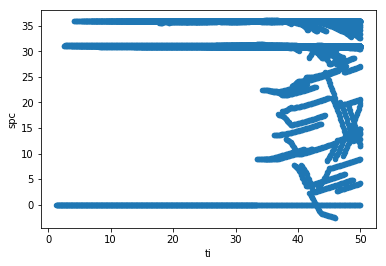

In [52]:
dataDf.plot(kind='scatter',x='ti',y ='spc')
plt.show()